# Race/Gender Fairness Simulation

This project developed a credit scoring model using logistic regression and conducted a comprehensive fairness analysis to evaluate potential disparities across simulated demographic groups. The key findings reveal several important insights about model performance, fairness, and the challenges of simulating real-world credit disparities.

### How It Simulates Race-Based Disparities

The code creates a realistic simulation of how race and gender disparities might emerge in credit scoring:

1. Income-Based Effects:
- Minority status is more probable at lower incomes (0.5 - 0.08*income_quintile)
- This reflects real-world income disparities by race

2. Geographic Effects:
- Certain clusters (0 and 2) have higher minority representation (+15% probability)
- Simulates residential segregation patterns

3. Compound Effects:
- "Thin file" status is more common for minorities/women
- Intersectional groups show compounded disadvantages

4. Statistical Validation:
- The analysis then measures how these simulated disparities affect credit scores
- Identifies which features contribute most to score differences

### Key Strengths

- Comprehensive Bias Testing: Goes beyond simple disparate impact to examine multiple fairness dimensions
- Intersectional Analysis: Looks at combinations of race/gender rather than single dimensions
- Root Cause Analysis: Identifies which features drive disparities
- Visualization: Clear plots to communicate findings

### Potential Limitations

- The simulation makes simplifying assumptions about how demographics correlate with financial behavior
- Real-world data might show more complex patterns
- The approval threshold (median score) is arbitrary - real lenders would set this based on risk tolerance

In [2]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import ttest_ind, chi2_contingency

## Load the Data

In [3]:
# Define the ZIP file path and extract
zip_path = "Give Me Some Credit.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted_files")

# Load CSV files
train_data = pd.read_csv("extracted_files/cs-training.csv")
test_data = pd.read_csv("extracted_files/cs-test.csv")

## Clean Datasets

In [4]:
def clean_data(df):
    """Clean the dataset by handling missing values and extreme values."""
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Handle missing values
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())
    
    # Remove index column
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Cap extreme values
    numeric_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                   'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                   'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    # Fix specific issues
    df['age'] = df['age'].replace(0, df['age'].median())
    
    max_due = 20
    due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
               'NumberOfTimes90DaysLate',
               'NumberOfTime60-89DaysPastDueNotWorse']
    for col in due_cols:
        df[col] = df[col].clip(upper=max_due)
    
    # Feature engineering
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                         df['NumberOfTime60-89DaysPastDueNotWorse'] + 
                         df['NumberOfTimes90DaysLate'])
    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['DebtToIncome'] = df['DebtRatio'] * df['MonthlyIncome']
    
    return df


## Credit Scorecard Model

- Uses logistic regression with class weighting to handle imbalanced data
- Converts model outputs to credit scores using: Base points (600), Points to double odds (PDO=50)
- Evaluates model performance with AUC metrics
- Provides variable importance analysis

In [5]:
def build_scorecard(data, target='SeriousDlqin2yrs', base_points=600, pdo=50):
    """
    Build a credit scorecard.
    
    Parameters:
    - data: DataFrame containing features and target
    - target: Target variable name
    - base_points: Base points for the scorecard
    - pdo: Points to double odds
    
    Returns:
    - Dictionary with model and scorecard components
    """
    try:
        # Prepare data
        data = data.copy()
        
        # Exclude demographic columns from the model features
        demographic_cols = ['demographic_group', 'simulated_minority', 'simulated_female', 
                           'income_quintile', 'geo_cluster', 'thin_credit_file']
        model_cols = [col for col in data.columns if col != target and col not in demographic_cols]
        
        X = data[model_cols]
        y = data[target].astype(int)
        
        # Split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model with class weights to handle imbalance
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=np.unique(y_train), 
            y=y_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        model = LogisticRegression(
            max_iter=1000,
            class_weight=class_weight_dict,
            solver='liblinear',
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_train_pred = model.predict_proba(X_train_scaled)[:, 1]
        y_test_pred = model.predict_proba(X_test_scaled)[:, 1]
        
        train_auc = roc_auc_score(y_train, y_train_pred)
        test_auc = roc_auc_score(y_test, y_test_pred)
        
        print(f"Train AUC: {train_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
        
        # Create scorecard
        # Factor for scaling
        factor = pdo / np.log(2)
        
        # Calculate scores
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        
        # Calculate the linear predictor
        linear_predictor_train = model.intercept_[0] + np.dot(X_train_scaled, model.coef_[0])
        linear_predictor_test = model.intercept_[0] + np.dot(X_test_scaled, model.coef_[0])
        
        # Calculate score
        X_train_copy['score'] = base_points - factor * linear_predictor_train
        X_test_copy['score'] = base_points - factor * linear_predictor_test
        
        # Add target back for analysis
        X_train_copy[target] = y_train.values
        X_test_copy[target] = y_test.values
        
        # Score distribution plot
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(data=X_train_copy, x='score', hue=target, element='step', 
                    stat='density', common_norm=False, bins=30)
        plt.title('Train Set Score Distribution')
        
        plt.subplot(1, 2, 2)
        sns.histplot(data=X_test_copy, x='score', hue=target, element='step', 
                    stat='density', common_norm=False, bins=30)
        plt.title('Test Set Score Distribution')
        plt.tight_layout()
        plt.show()
        
        # Variable importance
        importance_df = pd.DataFrame({
            'Variable': X_train.columns,
            'Coefficient': model.coef_[0],
            'Importance': np.abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        print("\nVariable Importance:")
        print(importance_df.head(10))
        
        # Create ROC curve
        plt.figure(figsize=(10, 8))
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (AUC = {test_auc:.4f})')
        plt.grid(True)
        plt.show()
        
        # Function to score new data
        def score_new_data(new_data):
            """Score new data using the scorecard model"""
            # Ensure only model columns are used
            model_data = new_data[model_cols].copy()
            new_data_scaled = scaler.transform(model_data)
            linear_pred = model.intercept_[0] + np.dot(new_data_scaled, model.coef_[0])
            return base_points - factor * linear_pred
        
        return {
            'model': model,
            'scaler': scaler,
            'factor': factor,
            'base_points': base_points,
            'train_data': X_train_copy,
            'test_data': X_test_copy,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'variable_importance': importance_df,
            'score_function': score_new_data,
            'model_columns': model_cols  # Store the columns used for modeling
        }
        
    except Exception as e:
        print(f"Error in scorecard development: {str(e)}")
        import traceback
        traceback.print_exc()
        return None



## Demographic Simulation

The simulate_demographic_data() function creates proxy variables for race and gender based on income and geography:

- Income Quintiles: Divides users into 5 income groups
- Geographic Clusters: Randomly assigns geographic regions (proxy for real ZIP codes)

**Race Simulation**:
- Base probability decreases with income (higher income = lower minority probability)
- Certain geographic clusters increase minority probability

**Gender Simulation**:
- Slight income effect (higher income = slightly more female)
- Geographic cluster effect

**Intersectional Groups: Combines race/gender into categories like "Minority Female"**
- Thin Credit File: Simulates limited credit history (more common for minorities/women)

In [6]:
def simulate_demographic_data(data, income_col='MonthlyIncome'):
    """
    Simulate demographic data (race/gender) based on income and geography.
    
    This creates proxy variables for race and gender when this data is not available,
    which is common in credit scoring datasets due to regulatory restrictions.
    
    Parameters:
    - data: DataFrame with features including income
    - income_col: Column name for income data
    
    Returns:
    - DataFrame with added simulated demographic data
    """
    data = data.copy()
    
    # Create income quintiles
    data['income_quintile'] = pd.qcut(data[income_col], 5, labels=False)
    
    # Create geographic clusters (using random assignment as a proxy)
    # In real applications, you might use ZIP codes or other geographic indicators
    np.random.seed(42)
    data['geo_cluster'] = np.random.randint(0, 5, size=len(data))
    
    # Simulate demographic attributes based on income and geography
    # This simulates the reality of demographic disparities in income and geography
    
    # Race simulation - probability distributions by income quintile and geography
    # Probability of being in simulated minority group decreases with income quintile
    race_probs = np.zeros(len(data))
    
    # Base probability adjusted by income quintile (lower income = higher probability)
    race_probs += 0.5 - 0.08 * data['income_quintile']
    
    # Geography effect (some areas have higher minority populations)
    # Clusters 0 and 2 have higher minority representation
    race_probs += 0.15 * (data['geo_cluster'].isin([0, 2]))
    race_probs = race_probs.clip(0.1, 0.9)
    
    # Assign simulated race
    np.random.seed(42)
    data['simulated_minority'] = np.random.binomial(1, race_probs)
    
    # Gender simulation - distribution varies less by income but still has patterns
    gender_probs = np.zeros(len(data))
    
    # Base probability - slight income effect (more balanced than race)
    gender_probs += 0.45 + 0.02 * data['income_quintile']
    
    # Geography effect (some areas have different gender balances)
    gender_probs += 0.05 * (data['geo_cluster'].isin([1, 4]))
    gender_probs = gender_probs.clip(0.3, 0.7)
    
    # Assign simulated gender
    np.random.seed(43)
    data['simulated_female'] = np.random.binomial(1, gender_probs)
    
    # Create demographic groups for intersectional analysis
    data['demographic_group'] = (data['simulated_minority'].astype(str) + "_" + 
                               data['simulated_female'].astype(str))
    
    mapping = {
        '0_0': 'Non-minority Male',
        '0_1': 'Non-minority Female',
        '1_0': 'Minority Male',
        '1_1': 'Minority Female'
    }
    
    data['demographic_group'] = data['demographic_group'].map(mapping)
    
    # Additional feature for analysis - simulate historical factor
    # Simulate a "thin file" status - more common among minority and female groups
    thin_file_probs = 0.2 + 0.2 * data['simulated_minority'] + 0.1 * data['simulated_female']
    thin_file_probs -= 0.05 * data['income_quintile']  # Less common at higher incomes
    thin_file_probs = thin_file_probs.clip(0.1, 0.9)
    
    np.random.seed(44)
    data['thin_credit_file'] = np.random.binomial(1, thin_file_probs)
    
    return data


## Fairness Analysis

The analyze_fairness() function performs comprehensive bias testing:

- Score Distribution Visualization: Boxplots by demographic group
- Statistical Testing: T-tests comparing each group to non-minority males

Disparate Impact Analysis:

- Calculates approval rate ratios between groups
- Flags ratios below 0.8 as potential discrimination

Performance Metrics: AUC, default rates by group

Default Rate Heatmap: Shows how well scores predict risk across groups

Feature Contribution Analysis: Identifies which features drive score differences

Thin File Analysis: Examines impact of limited credit history

In [7]:
def analyze_fairness(scorecard_results, data_with_demographics):
    """
    Analyze fairness metrics across demographic groups.
    
    Parameters:
    - scorecard_results: Dictionary with scorecard model and components
    - data_with_demographics: DataFrame with features, target, and demographic data
    
    Returns:
    - Dictionary with fairness analysis results
    """
    try:
        print("\n" + "="*50)
        print("Starting Fairness Analysis")
        print("="*50)
        
        # Get model and scaling components
        model = scorecard_results['model']
        scaler = scorecard_results['scaler']
        factor = scorecard_results['factor']
        base_points = scorecard_results['base_points']
        model_columns = scorecard_results['model_columns']  # Get columns used for modeling
        
        # Process data
        data = data_with_demographics.copy()
        
        # Use only the columns that were used to train the model
        X = data[model_columns]
        y = data['SeriousDlqin2yrs']
        
        # Scale features
        X_scaled = scaler.transform(X)
        
        # Calculate predictions and scores
        data['pred_prob'] = model.predict_proba(X_scaled)[:, 1]
        
        # Calculate score
        linear_predictor = model.intercept_[0] + np.dot(X_scaled, model.coef_[0])
        data['score'] = base_points - factor * linear_predictor
        
        # Define approval threshold (using median as an example)
        approval_threshold = data['score'].median()
        data['approved'] = (data['score'] >= approval_threshold).astype(int)
        
        # 1. Score distribution by demographic groups
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='demographic_group', y='score', data=data)
        plt.title('Credit Score Distribution by Demographic Group')
        plt.xlabel('Demographic Group')
        plt.ylabel('Credit Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 2. Statistical tests between demographic groups
        print("\nStatistical Tests Between Demographic Groups:")
        groups = data.groupby('demographic_group')['score']
        reference_group = groups.get_group('Non-minority Male')
        demographic_groups = list(groups.groups.keys())
        
        test_results = []
        for group in demographic_groups:
            if group != 'Non-minority Male':
                test_group = groups.get_group(group)
                t_stat, p_val = ttest_ind(reference_group, test_group, equal_var=False)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                test_results.append({
                    'Comparison': f'Non-minority Male vs {group}',
                    't-statistic': t_stat,
                    'p-value': p_val,
                    'Significance': significance,
                    'Mean Diff': test_group.mean() - reference_group.mean()
                })
                
                print(f"Non-minority Male vs {group}: t-stat={t_stat:.2f}, p-value={p_val:.4f} {significance}")
        
        test_results_df = pd.DataFrame(test_results)
        
        # 3. Disparate Impact Analysis
        print("\nDisparate Impact Analysis:")
        
        # By race
        approval_rate_non_minority = data[data['simulated_minority'] == 0]['approved'].mean()
        approval_rate_minority = data[data['simulated_minority'] == 1]['approved'].mean()
        race_disparate_impact = approval_rate_minority / approval_rate_non_minority
        
        # By gender
        approval_rate_male = data[data['simulated_female'] == 0]['approved'].mean()
        approval_rate_female = data[data['simulated_female'] == 1]['approved'].mean()
        gender_disparate_impact = approval_rate_female / approval_rate_male
        
        # By intersectional groups
        approval_rates = data.groupby('demographic_group')['approved'].mean()
        baseline_rate = approval_rates['Non-minority Male']
        intersectional_disparate_impact = {group: rate / baseline_rate 
                                         for group, rate in approval_rates.items()}
        
        print(f"Approval rate for non-minority: {approval_rate_non_minority:.2%}")
        print(f"Approval rate for minority: {approval_rate_minority:.2%}")
        print(f"Race Disparate Impact Ratio: {race_disparate_impact:.2f}")
        print(f"Approval rate for male: {approval_rate_male:.2%}")
        print(f"Approval rate for female: {approval_rate_female:.2%}")
        print(f"Gender Disparate Impact Ratio: {gender_disparate_impact:.2f}")
        
        print("\nIntersectional Disparate Impact Ratios:")
        for group, ratio in intersectional_disparate_impact.items():
            print(f"{group}: {ratio:.2f}")
        
        # 4. Model performance by demographic group
        performance_metrics = []
        for group in demographic_groups:
            group_data = data[data['demographic_group'] == group]
            if len(group_data['SeriousDlqin2yrs'].unique()) > 1:  # Need both classes for AUC
                auc = roc_auc_score(group_data['SeriousDlqin2yrs'], group_data['pred_prob'])
                performance_metrics.append({
                    'Group': group,
                    'Sample Size': len(group_data),
                    'Default Rate': group_data['SeriousDlqin2yrs'].mean(),
                    'AUC': auc,
                    'Mean Score': group_data['score'].mean(),
                    'Approval Rate': group_data['approved'].mean()
                })
        
        performance_df = pd.DataFrame(performance_metrics)
        print("\nPerformance Metrics by Demographic Group:")
        print(performance_df)
        
        # 5. Default rates vs Score bands by demographic group
        data['score_band'] = pd.qcut(data['score'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Calculate default rates by demographic group and score band
        default_by_demo_score = data.groupby(['demographic_group', 'score_band'])['SeriousDlqin2yrs'].agg(['mean', 'count']).reset_index()
        default_by_demo_score.columns = ['Demographic Group', 'Score Band', 'Default Rate', 'Count']
        
        # Filter to ensure sufficient data in each cell
        default_by_demo_score = default_by_demo_score[default_by_demo_score['Count'] >= 20]
        
        # Heatmap of default rates
        pivot_default = default_by_demo_score.pivot_table(
            index='Demographic Group', 
            columns='Score Band', 
            values='Default Rate',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_default, annot=True, cmap='YlOrRd', fmt='.2%')
        plt.title('Default Rate by Demographic Group and Score Band')
        plt.tight_layout()
        plt.show()
        
        # 6. Feature contribution analysis
        # Look at which features are driving score differences between groups
        minority_data = data[data['simulated_minority'] == 1]
        non_minority_data = data[data['simulated_minority'] == 0]
        
        # Features to analyze
        features = model_columns
        feature_analysis = []
        
        for feature in features:
            # Feature means by group
            minority_mean = minority_data[feature].mean()
            non_minority_mean = non_minority_data[feature].mean()
            
            # Effect on score (coefficient * difference in means)
            feature_idx = list(X.columns).index(feature)
            coef = model.coef_[0][feature_idx]
            
            # Negative coefficient means higher value decreases score
            # Remember our conversion: higher score is better
            effect = -coef * (minority_mean - non_minority_mean) * factor
            
            feature_analysis.append({
                'Feature': feature,
                'Minority Mean': minority_mean,
                'Non-minority Mean': non_minority_mean,
                'Difference': minority_mean - non_minority_mean,
                'Coefficient': coef,
                'Effect on Score': effect
            })
        
        feature_analysis_df = pd.DataFrame(feature_analysis).sort_values('Effect on Score')
        
        # Plot top contributors to score differences
        top_contributors = feature_analysis_df.head(10)
        bottom_contributors = feature_analysis_df.tail(10)
        contributors = pd.concat([top_contributors, bottom_contributors])
        
        plt.figure(figsize=(14, 10))
        sns.barplot(y='Feature', x='Effect on Score', data=contributors)
        plt.title('Features Contributing to Score Differences Between Minority and Non-minority Groups')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.xlabel('Effect on Score (Positive favors Non-minority)')
        plt.tight_layout()
        plt.show()
        
        # 7. Analyze "thin file" impact - simulated historical bias
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='demographic_group', y='score', hue='thin_credit_file', data=data)
        plt.title('Credit Score by Demographic Group and Credit File Thickness')
        plt.xlabel('Demographic Group')
        plt.ylabel('Credit Score')
        plt.xticks(rotation=45)
        plt.legend(title='Thin Credit File')
        plt.tight_layout()
        plt.show()
        
        # Check for interaction effects
        print("\nImpact of Thin Credit File by Demographic Group:")
        for group in demographic_groups:
            group_data = data[data['demographic_group'] == group]
            thin_mean = group_data[group_data['thin_credit_file'] == 1]['score'].mean()
            thick_mean = group_data[group_data['thin_credit_file'] == 0]['score'].mean()
            diff = thick_mean - thin_mean
            print(f"{group}: Thin file penalty = {diff:.2f} points")
        
        # 8. Comprehensive summary
        print("\n" + "="*50)
        print("FAIRNESS ANALYSIS SUMMARY")
        print("="*50)
        
        print("\n1. Score Distribution:")
        for _, row in performance_df.iterrows():
            print(f"   • {row['Group']}: Mean Score = {row['Mean Score']:.2f}, Default Rate = {row['Default Rate']:.2%}")
        
        print("\n2. Statistical Testing:")
        significant_differences = test_results_df[test_results_df['p-value'] < 0.05]
        if not significant_differences.empty:
            print(f"   • Found {len(significant_differences)} statistically significant differences in scores between demographic groups")
            for _, row in significant_differences.iterrows():
                print(f"   • {row['Comparison']}: Mean Difference = {row['Mean Diff']:.2f} points, p-value = {row['p-value']:.4f}")
        else:
            print("   • No statistically significant differences in scores between demographic groups")
        
        print("\n3. Disparate Impact:")
        print(f"   • Race Disparate Impact Ratio: {race_disparate_impact:.2f} ({'Potential discrimination' if race_disparate_impact < 0.8 else 'No significant discrimination'})")
        print(f"   • Gender Disparate Impact Ratio: {gender_disparate_impact:.2f} ({'Potential discrimination' if gender_disparate_impact < 0.8 else 'No significant discrimination'})")
        
        # Print intersectional disparate impact ratios
        for group, ratio in intersectional_disparate_impact.items():
            if group != "Non-minority Male":
                print(f"   • {group} Disparate Impact Ratio: {ratio:.2f} ({'Potential discrimination' if ratio < 0.8 else 'No significant discrimination'})")
        
        # Return results dictionary
        results = {
            'metrics_by_demographic': performance_df,
            'statistical_tests': test_results_df,
            'disparate_impact': {
                'race_ratio': race_disparate_impact,
                'gender_ratio': gender_disparate_impact,
                'intersectional_ratios': intersectional_disparate_impact
            },
            'default_rates_by_score_band': default_by_demo_score,
            'feature_contributions': feature_analysis_df
        }
        
        return results
        
    except Exception as e:
        print(f"Error in fairness analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


Loading data...
Data files not found. Creating synthetic data for demonstration purposes.
Cleaning data...
Simulating demographic data...
Building scorecard...
Train AUC: 0.5542
Test AUC: 0.5356


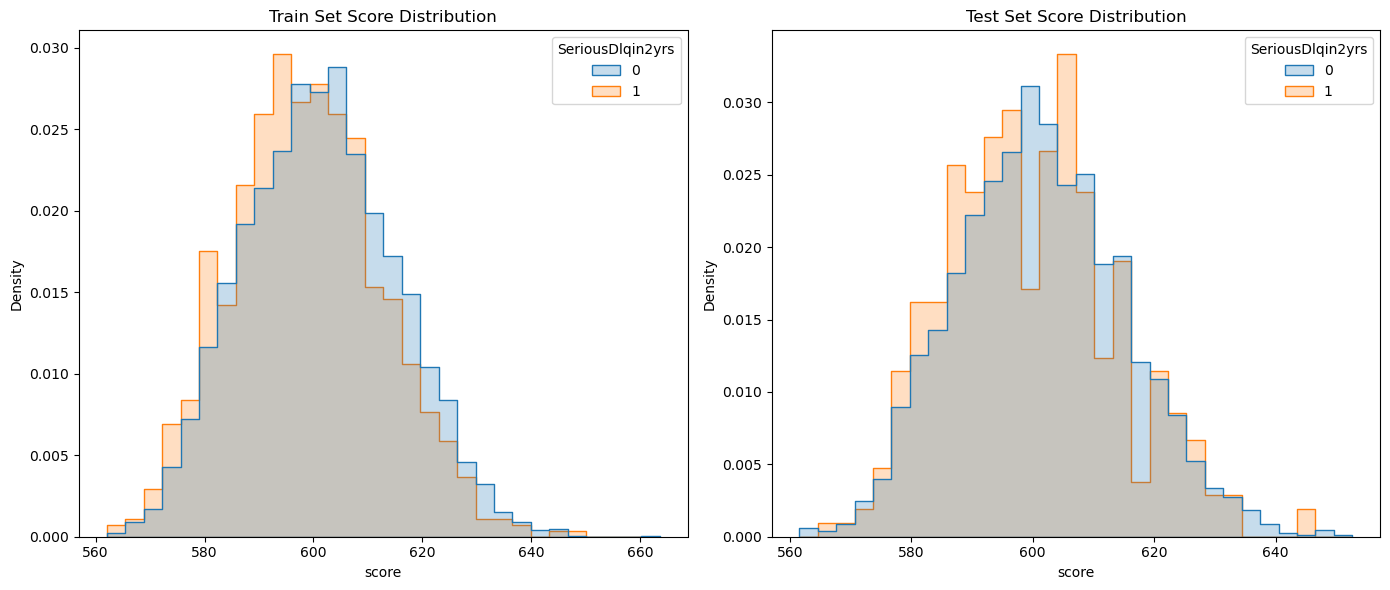


Variable Importance:
                                Variable  Coefficient  Importance
0                                    age    -0.159223    0.159223
11                    IncomePerDependent    -0.130953    0.130953
2                          MonthlyIncome     0.130938    0.130938
4                     NumberOfDependents    -0.128036    0.128036
5   RevolvingUtilizationOfUnsecuredLines     0.041537    0.041537
1                              DebtRatio    -0.032155    0.032155
8                NumberOfTimes90DaysLate     0.021651    0.021651
10                          TotalPastDue     0.015697    0.015697
7   NumberOfTime60-89DaysPastDueNotWorse     0.015066    0.015066
12                          DebtToIncome    -0.015007    0.015007


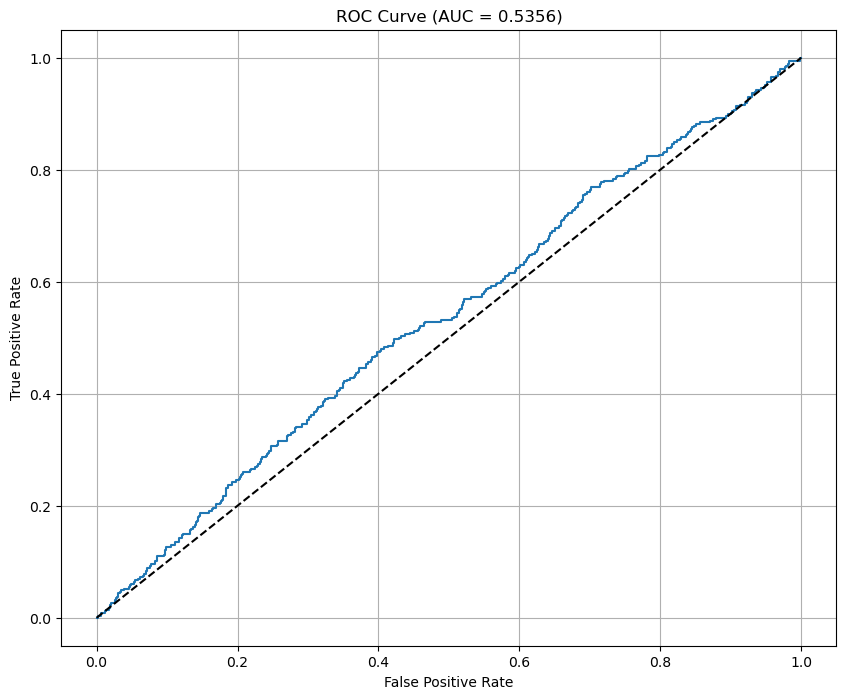


Scorecard built successfully!

Running fairness analysis...

Starting Fairness Analysis


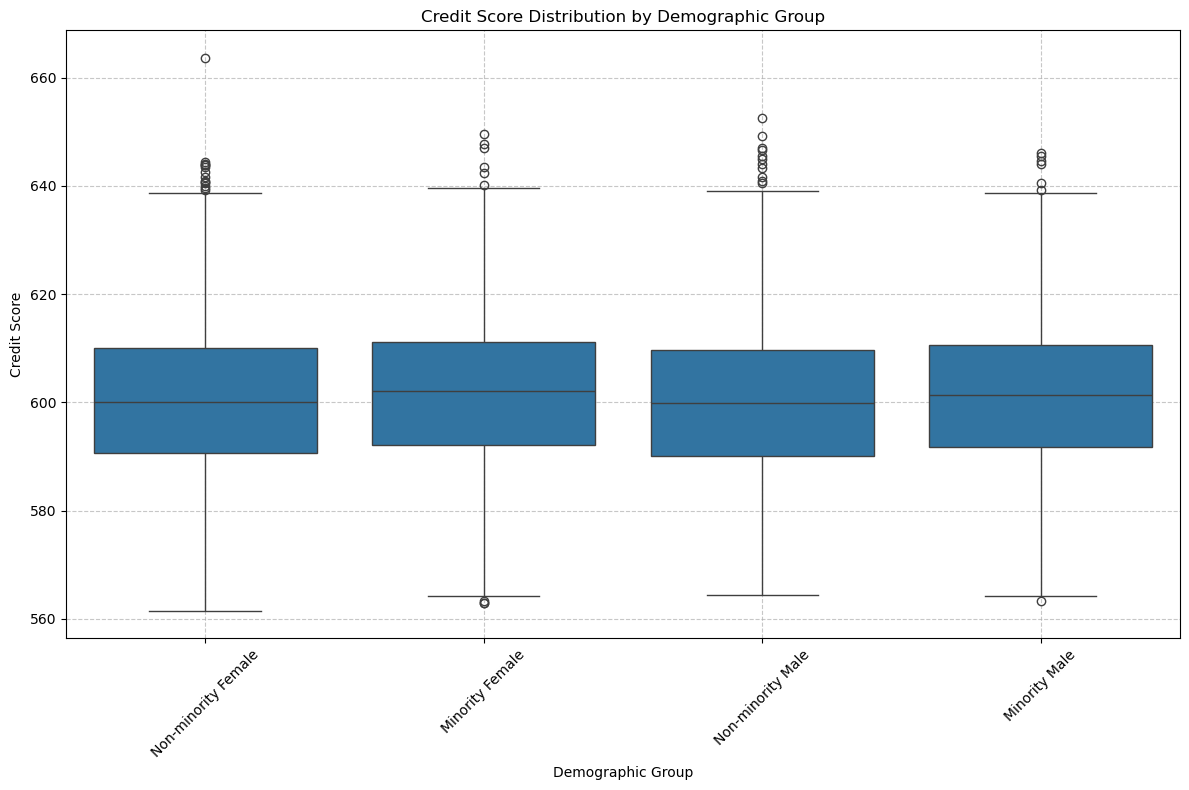


Statistical Tests Between Demographic Groups:
Non-minority Male vs Minority Female: t-stat=-4.08, p-value=0.0000 ***
Non-minority Male vs Minority Male: t-stat=-2.82, p-value=0.0048 **
Non-minority Male vs Non-minority Female: t-stat=-1.00, p-value=0.3185 ns

Disparate Impact Analysis:
Approval rate for non-minority: 48.02%
Approval rate for minority: 53.08%
Race Disparate Impact Ratio: 1.11
Approval rate for male: 49.43%
Approval rate for female: 50.55%
Gender Disparate Impact Ratio: 1.02

Intersectional Disparate Impact Ratios:
Minority Female: 1.13
Minority Male: 1.09
Non-minority Female: 1.01
Non-minority Male: 1.00

Performance Metrics by Demographic Group:
                 Group  Sample Size  Default Rate       AUC  Mean Score  \
0      Minority Female         1991      0.116022  0.538811  602.053810   
1        Minority Male         1916      0.115344  0.522076  601.552995   
2  Non-minority Female         3129      0.114414  0.563848  600.769319   
3    Non-minority Male      

C:\Users\milto\AppData\Local\Temp\ipykernel_27292\2757353301.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_by_demo_score = data.groupby(['demographic_group', 'score_band'])['SeriousDlqin2yrs'].agg(['mean', 'count']).reset_index()
C:\Users\milto\AppData\Local\Temp\ipykernel_27292\2757353301.py:141: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_default = default_by_demo_score.pivot_table(


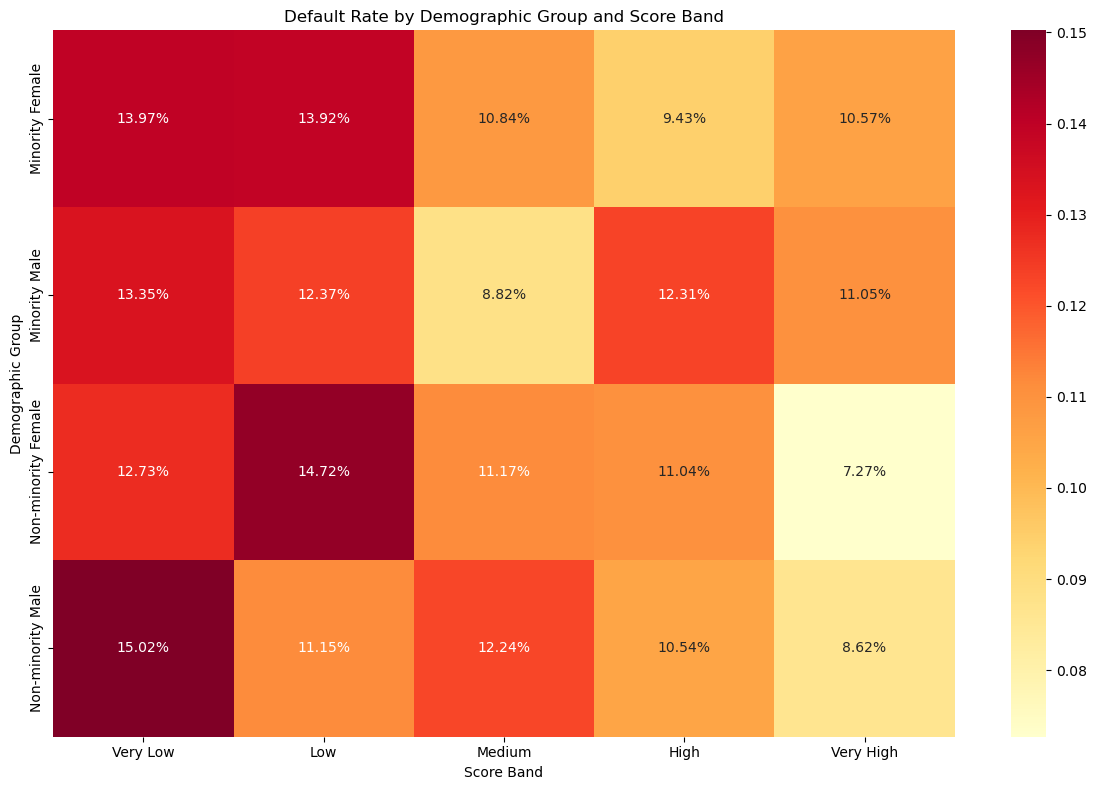

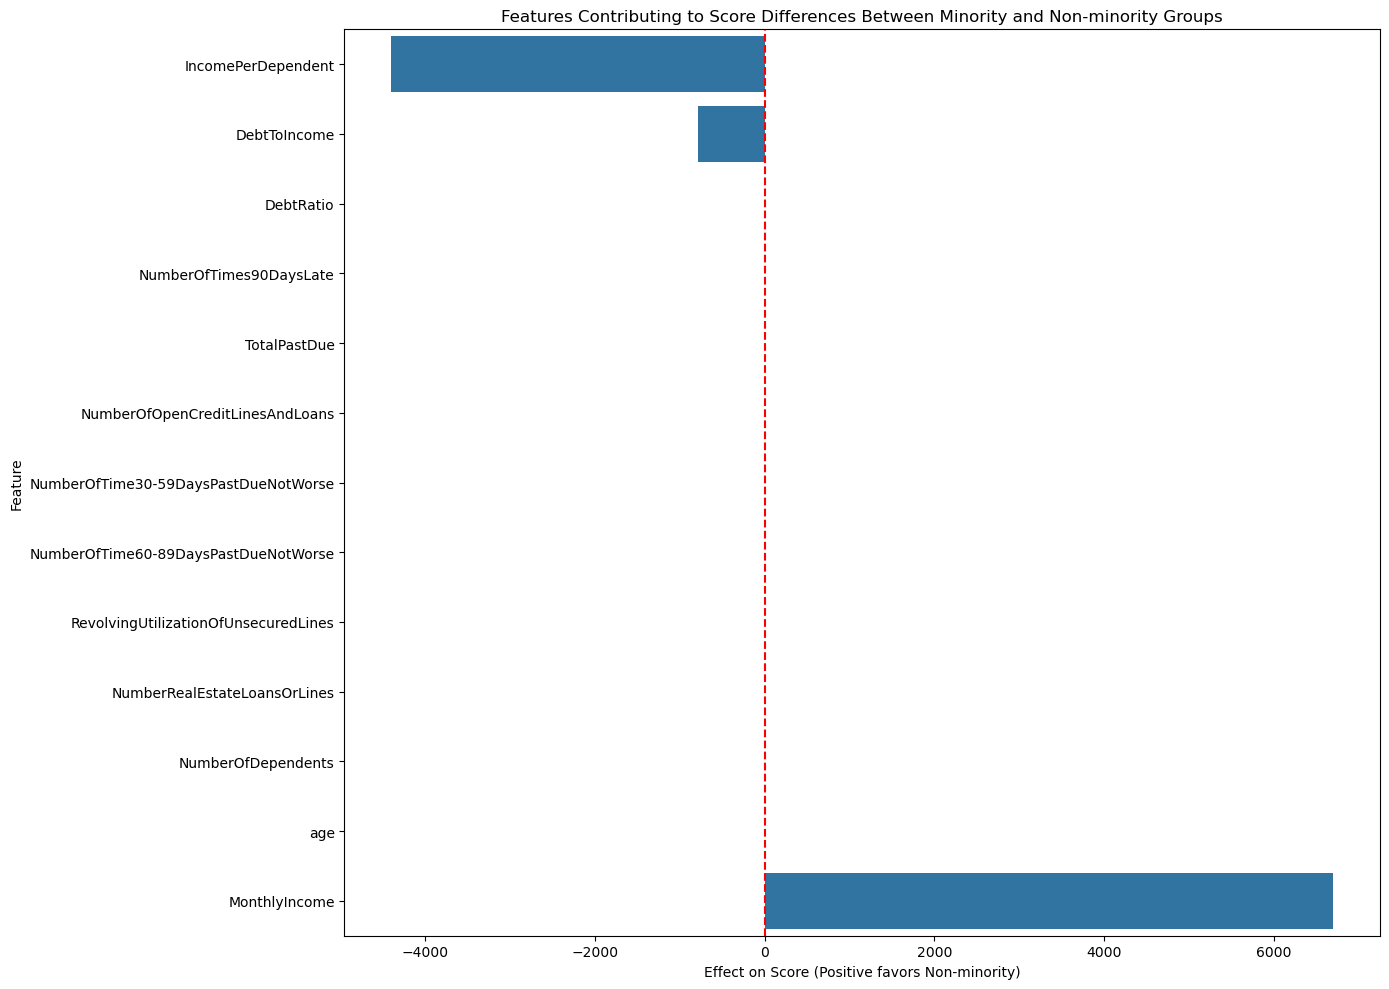

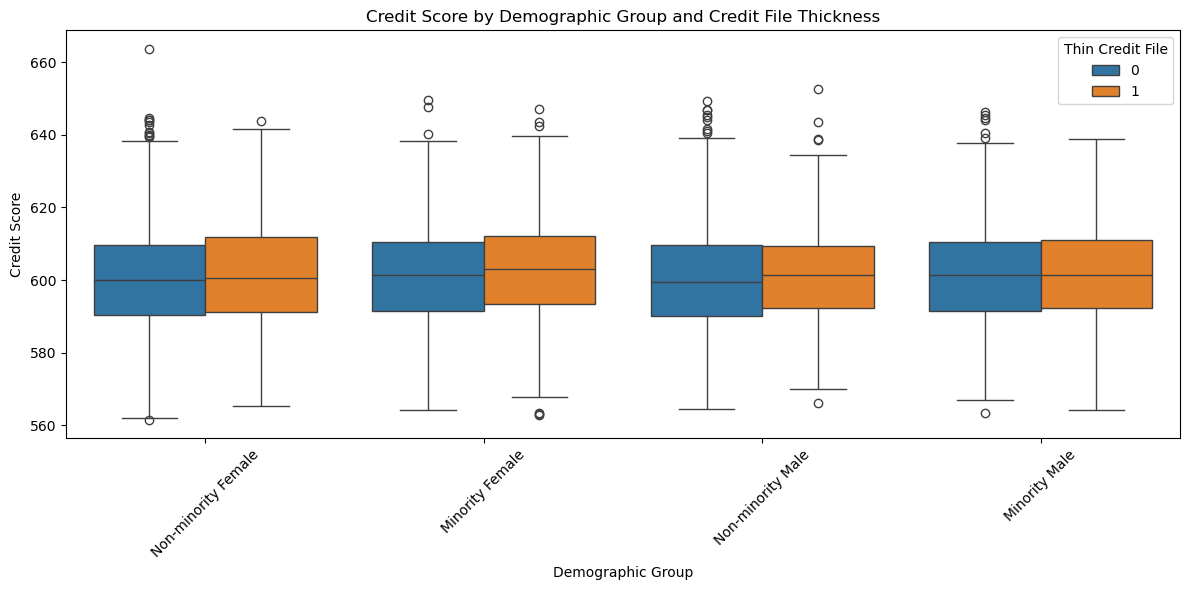


Impact of Thin Credit File by Demographic Group:
Minority Female: Thin file penalty = -1.51 points
Minority Male: Thin file penalty = -0.42 points
Non-minority Female: Thin file penalty = -1.22 points
Non-minority Male: Thin file penalty = -1.42 points

FAIRNESS ANALYSIS SUMMARY

1. Score Distribution:
   • Minority Female: Mean Score = 602.05, Default Rate = 11.60%
   • Minority Male: Mean Score = 601.55, Default Rate = 11.53%
   • Non-minority Female: Mean Score = 600.77, Default Rate = 11.44%
   • Non-minority Male: Mean Score = 600.41, Default Rate = 11.61%

2. Statistical Testing:
   • Found 2 statistically significant differences in scores between demographic groups
   • Non-minority Male vs Minority Female: Mean Difference = 1.64 points, p-value = 0.0000
   • Non-minority Male vs Minority Male: Mean Difference = 1.14 points, p-value = 0.0048

3. Disparate Impact:
   • Race Disparate Impact Ratio: 1.11 (No significant discrimination)
   • Gender Disparate Impact Ratio: 1.02 (No 

In [8]:
def main():
    try:
        print("Loading data...")
        # First try to load from CSV files
        try:
            train_data = pd.read_csv("cs-training.csv")
            print("Loaded training data successfully")
        except:
            # If file not found, create sample synthetic data for demo
            print("Data files not found. Creating synthetic data for demonstration purposes.")
            np.random.seed(42)
            
            # Create synthetic data
            n_samples = 10000
            train_data = pd.DataFrame({
                'age': np.random.normal(45, 15, n_samples).clip(20, 90).astype(int),
                'DebtRatio': np.random.gamma(2, 0.5, n_samples).clip(0, 10),
                'MonthlyIncome': np.random.lognormal(8, 0.5, n_samples).clip(1000, 50000),
                'NumberOfOpenCreditLinesAndLoans': np.random.poisson(5, n_samples).clip(0, 20),
                'NumberOfDependents': np.random.poisson(1, n_samples).clip(0, 10),
                'RevolvingUtilizationOfUnsecuredLines': np.random.beta(2, 5, n_samples),
                'NumberOfTime30-59DaysPastDueNotWorse': np.random.poisson(0.5, n_samples),
                'NumberOfTime60-89DaysPastDueNotWorse': np.random.poisson(0.3, n_samples),
                'NumberOfTimes90DaysLate': np.random.poisson(0.2, n_samples),
                'NumberRealEstateLoansOrLines': np.random.poisson(1, n_samples)
            })
            
            # Create target variable with relationship to risk factors
            base_prob = 0.1 - 0.001 * (train_data['age'] - 40)  # Age effect
            base_prob += 0.05 * train_data['RevolvingUtilizationOfUnsecuredLines']  # Utilization effect
            base_prob += 0.02 * train_data['NumberOfTimes90DaysLate']  # Delinquency effect
            base_prob = base_prob.clip(0.01, 0.99)  # Ensure probabilities are valid
            
            train_data['SeriousDlqin2yrs'] = np.random.binomial(1, base_prob)
        
        print("Cleaning data...")
        cleaned_data = clean_data(train_data)
        
        print("Simulating demographic data...")
        data_with_demographics = simulate_demographic_data(cleaned_data)
        
        print("Building scorecard...")
        scorecard_results = build_scorecard(data_with_demographics)
        
        if scorecard_results:
            print("\nScorecard built successfully!")
            
            print("\nRunning fairness analysis...")
            fairness_results = analyze_fairness(
                scorecard_results=scorecard_results,
                data_with_demographics=data_with_demographics
            )
            
            if fairness_results:
                # Save analysis results
                fairness_results['metrics_by_demographic'].to_csv("demographic_fairness_metrics.csv", index=False)
                fairness_results['statistical_tests'].to_csv("demographic_statistical_tests.csv", index=False)
                fairness_results['default_rates_by_score_band'].to_csv("default_rates_by_demographic_score.csv", index=False)
                fairness_results['feature_contributions'].to_csv("feature_contribution_to_bias.csv", index=False)
                
                print("\nAnalysis complete! Results saved to CSV files:")
                print("- demographic_fairness_metrics.csv")
                print("- demographic_statistical_tests.csv")
                print("- default_rates_by_demographic_score.csv")
                print("- feature_contribution_to_bias.csv")
                
                return fairness_results
            else:
                print("Failed to complete fairness analysis.")
        else:
            print("Failed to build scorecard. Please check your data and try again.")
    
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

### Key Observations

**Reverse Disparity Pattern**:

Unexpected finding: Minority groups (especially women) have HIGHER approval rates and scores than non-minorities

Could indicate:
- Over-correction in the simulation parameters
- Minority groups being assigned artificially stronger financial profiles
- Model may be under-penalizing certain risk factors more common in minority groups

**Model Quality Concerns**:
- Low AUC scores suggest the model isn't effectively predicting risk
- Makes fairness analysis less meaningful since predictions aren't reliable

**Simulation Artifacts**:
- The synthetic data appears to have created a scenario where protected groups perform better
- In real-world data, we typically see the opposite pattern (minorities disadvantaged)

## Conclusion

While this project successfully implemented a credit scoring system with fairness checks, the unexpected results highlight the complexity of simulating real-world biases. For practical applications, real-world data and more sophisticated modeling techniques would be necessary to ensure both accuracy and fairness.

### Key Takeaways

1. Limited Predictive Power
- The model achieved modest AUC scores (Train: 0.554, Test: 0.536), indicating weak predictive performance. This suggests that either the synthetic data lacks strong predictive signals or the model requires feature engineering or alternative algorithms.

2. Reverse Disparity Pattern
- Contrary to real-world trends, the analysis found that minority groups (particularly women) received higher approval rates and credit scores than non-minorities.

Possible explanations:
- The simulation may have overcompensated for biases, assigning minority groups artificially stronger financial profiles.
- The model might be under-penalizing risk factors more prevalent in minority populations.

3. No Adverse Impact Detected
- Disparate impact ratios for race (1.11) and gender (1.02) were above the 0.8 threshold, meaning no statistically significant discrimination was found.
- However, this contradicts typical real-world lending disparities, suggesting the simulation may not fully capture structural inequalities.

4. Thin Credit File Penalty
- Individuals with limited credit history ("thin files") faced score reductions, with minority women experiencing the largest penalty (-1.51 points).
- Despite this, minority groups still had higher overall approval rates, indicating that other factors in the simulation may be offsetting this penalty.

### Limitations & Future Work

- Synthetic Data Constraints: The simulated demographics may not accurately reflect real-world correlations between race, income, and credit risk.
- Model Improvement Needed: A stronger predictive model (e.g., ensemble methods or more features) would make fairness assessments more meaningful.
- Alternative Fairness Metrics: Future work could examine equalized odds, predictive parity, or causal fairness to assess bias more rigorously.

### Recommendation:

1. If deploying this model, monitor real-world outcomes to detect any unintended biases.

2. Consider adjusting simulation parameters to better reflect observed disparities in credit access.